<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [16]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

'deepul'에 복제합니다...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182 (from 1)
오브젝트를 받는 중: 100% (254/254), 94.70 MiB | 11.60 MiB/s, 완료.
델타를 알아내는 중: 100% (95/95), 완료.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=ff2547bdc7021c17bb8168c2348ffa5a9825f4d9d82aa3484063bca8d5d8a182
  Stored in directory: /tmp/pip-ephem-wheel-cache-04vlgv2t/wheels/4b/8a/c1/2cf0842d07377b0ebdedc79e46a3bb4492fa986def625118dc
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [1]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


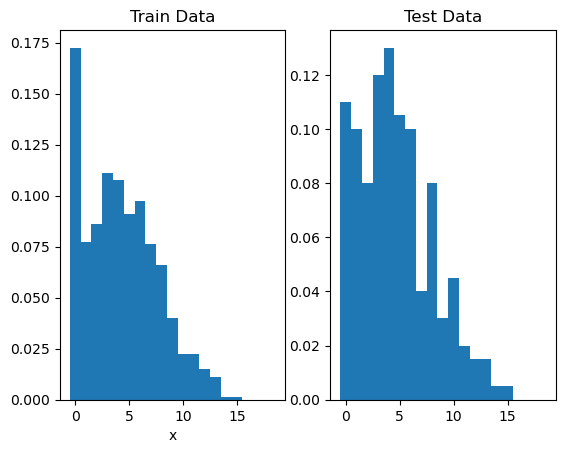

Dataset 2


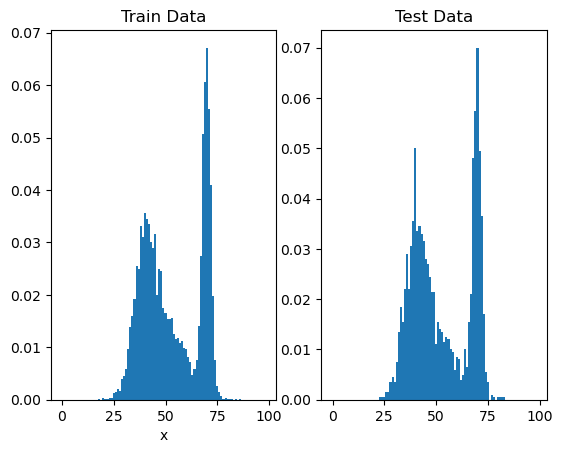

In [2]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
  """

    dataset_config = {
        1: {'lr': 0.05, 'batch_size': 32, 'epochs': 100},
        2: {'lr': 0.05, 'batch_size': 32, 'epochs': 100}
    }
    config = dataset_config[dset_id]
    lr, batch_size, epochs = config['lr'], config['batch_size'], config['epochs']

    # Step 1: Prepare dataset
    train_tensor = torch.tensor(train_data, dtype=torch.long)
    test_tensor = torch.tensor(test_data, dtype=torch.long)
    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    # Step 2: Prepare parameters to train
    theta = torch.zeros(d, requires_grad=True, device="cuda")

    # Step 3: Prepare optimizer to be later be used for learning. SGD
    optimizer = torch.optim.SGD([theta], lr=lr)

    def compute_nll(x_batch, theta, track_grad=False):
        if not track_grad:
            with torch.no_grad():
                log_probs = F.log_softmax(theta, dim=0)
                return -log_probs[x_batch].mean().item()
        else:
            log_probs = F.log_softmax(theta, dim=0)
            return -log_probs[x_batch].mean()

    train_losses = []
    test_losses = []

    # Step 5: Initial test loss (before training)
    test_tensor = test_tensor.to(theta.device)
    test_losses.append(compute_nll(test_tensor, theta))

    # Step 6: Training loop
    for epoch in tqdm(range(epochs)):
        for batch in train_loader:
            x_batch = batch[0].to(theta.device)
            loss = compute_nll(x_batch, theta, track_grad=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # After each epoch, evaluate test loss
        test_losses.append(compute_nll(test_tensor, theta))

    # Step 7: Convert θ to a probability distribution
    with torch.no_grad():
        distribution = F.softmax(theta, dim=0).cpu().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 2.5592


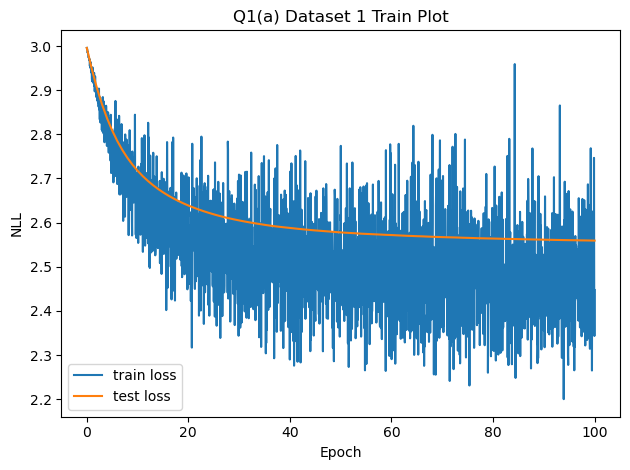

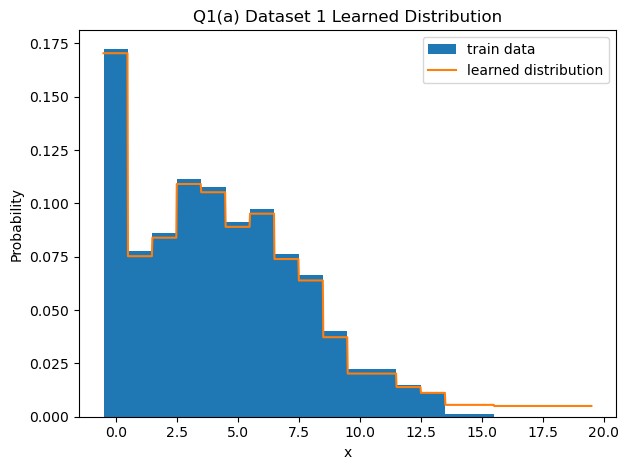

In [4]:
q1_save_results(1, 'a', q1_a)

  0%|          | 0/100 [00:00<?, ?it/s]

Final Test Loss: 3.6946


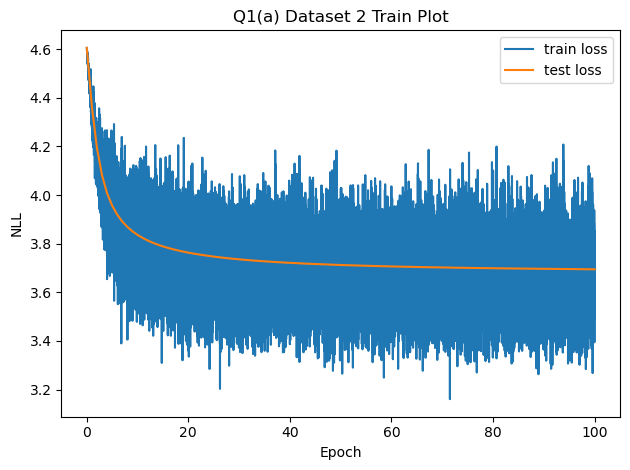

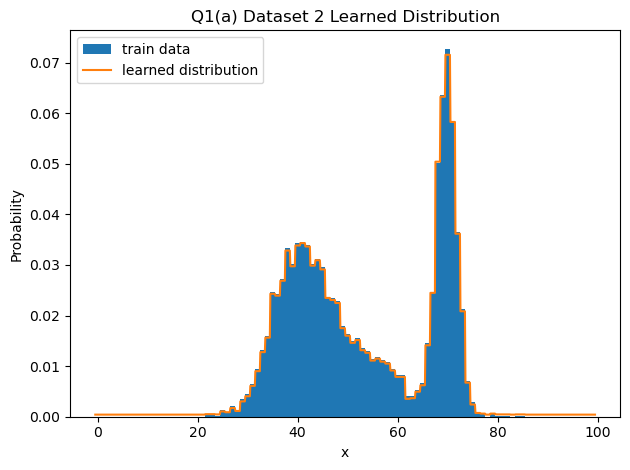

In [5]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [7]:
class MixedCDF(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.means = nn.Parameter(torch.linspace(0, d, 4))
        self.log_scales = nn.Parameter(torch.zeros(4))
        self.logits_pi = nn.Parameter(torch.zeros(4))
        self.d = d
        self.eps = 1e-12 # to avoid log(0)
    
    @property
    def device(self):
        return next(self.parameters()).device

    def calculate_px(self, x) -> torch.Tensor:
        scales = torch.exp(self.log_scales)
        pi = F.softmax(self.logits_pi, dim=0)

        upper = torch.sigmoid((x.unsqueeze(1) + 0.5 - self.means) / scales) # shape (B, 4)
        lower = torch.sigmoid((x.unsqueeze(1) - 0.5 - self.means) / scales)

        upper = torch.where(x.unsqueeze(1) == 99, torch.ones_like(upper), upper)
        lower = torch.where(x.unsqueeze(1) == 0, torch.zeros_like(lower), lower)

        probabilities = upper - lower
        weighted_probabilities = probabilities * pi
        total_probability = weighted_probabilities.sum(dim=1)

        return total_probability # shape (B,)
    
    def loss(self, x):
        return -torch.log(self.calculate_px(x) + self.eps).mean()
    
    @torch.no_grad()
    def test_loss(self, test_loader) -> float:
        self.eval()
        total_loss, total_count = 0.0, 0
        for x in test_loader:
            x = x.to(self.device)
            batch_size = x.shape[0]
            total_loss += self.loss(x).item() * batch_size
            total_count += batch_size
        return total_loss / total_count
    
    @torch.no_grad()
    def distribution(self):
        x = torch.arange(0, self.d, device=self.device).float()
        p_distribution = self.calculate_px(x)
        norm = p_distribution.sum()
        return (p_distribution / norm).cpu().numpy()
    

def q1_b(train_data, test_data, d, dset_id):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset_config = {
        1: {'lr': 0.05, 'batch_size': 32, 'epochs': 50},
        2: {'lr': 0.05, 'batch_size': 32, 'epochs': 50}
    }
    config = dataset_config[dset_id]
    lr, batch_size, epochs = config['lr'], config['batch_size'], config['epochs']

    model = MixedCDF(d).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        test_data, batch_size=len(test_data), shuffle=False)
    train_losses, test_losses = [], []
    test_losses.append(model.test_loss(test_loader))

    for epoch in tqdm(range(epochs)):
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        test_losses.append(model.test_loss(test_loader))
    distribution = model.distribution()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



  0%|          | 0/50 [00:00<?, ?it/s]

Final Test Loss: 2.5565


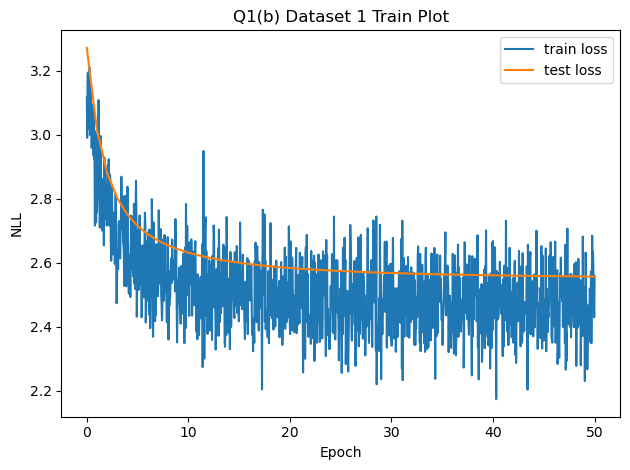

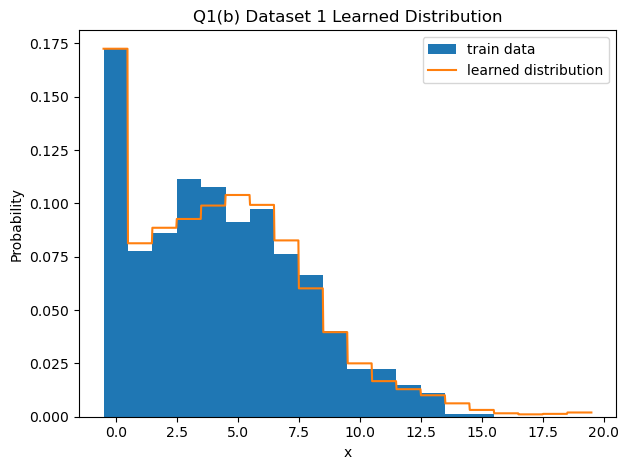

In [8]:
q1_save_results(1, 'b', q1_b)

  0%|          | 0/50 [00:00<?, ?it/s]

Final Test Loss: 3.7066


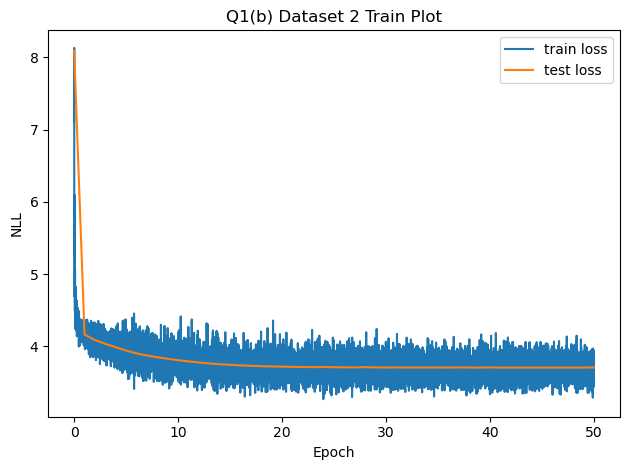

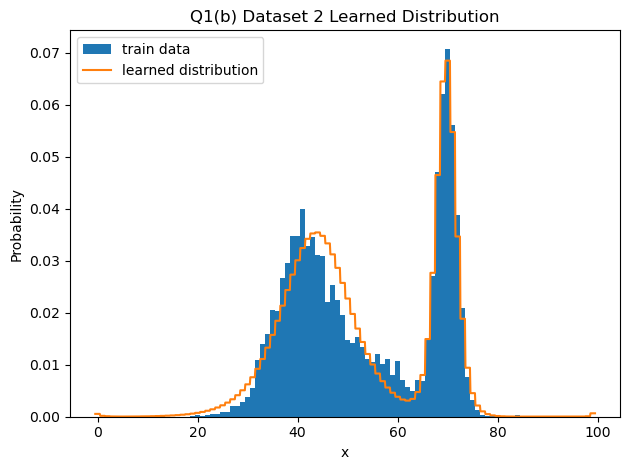

In [9]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

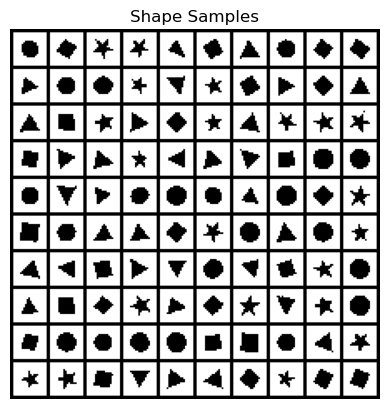

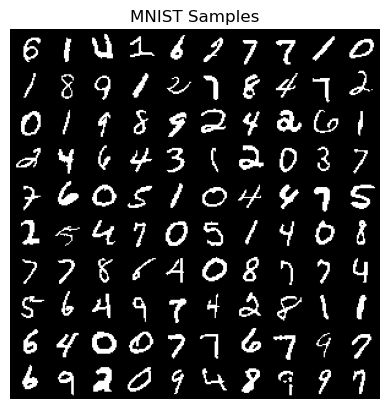

In [10]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskConvolution(nn.Conv2d):
    def __init__(self, input_channels, output_channels, kernel_size, mask_type, padding='same'):
        assert mask_type in ['A', 'B'], "Wrong mask type"
        assert kernel_size % 2 == 1, "Kernal size should be odd number"
        super().__init__(input_channels, output_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones_like(self.weight))

        center_mask = 0 if mask_type == 'A' else 1
        kH, kW = self.kernel_size

        self.mask[:, :, kH//2, (kW//2 + center_mask):] = 0
        self.mask[:, :, kH//2+1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, out_channels=1):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.extend[MaskConvolution(in_channels, hidden_channels, 7, mask_type='A'), nn.ReLU()])
        for _ in range(5):
            self.layers.extend([MaskConvolution(hidden_channels, hidden_channels, 7, mask_type='B'), nn.ReLU()])
        self.layers.extend([MaskConvolution(hidden_channels, hidden_channels, 1, mask_type='B'), nn.ReLU()])
        self.layers.append(MaskConvolution(hidden_channels, out_channels, 1, mask_type='B'))

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        return self.layers(x)
    
    def loss(self, x):
        logits = self.forward(x)
        return F.binary_cross_entropy_with_logits(logits, x)

    @torch.no_grad()
    def test_loss(self, test_loader) -> float:
        self.eval()
        total_loss, total_count = 0.0, 0
        for x in test_loader:
            x = x.to(self.device)
            batch_size = x.shape[0]
            total_loss += self.loss(x).item() * batch_size
            total_count += batch_size
        return total_loss / total_count

    @torch.no_grad()
    def sample(self, num_samples, image_shape):
        self.eval()
        height, width = image_shape
        total_pixels = height * width
        samples = torch.zeros(num_samples, 1, height, width, device=self.device)
        for pixel_index in range(total_pixels):
            logits = self.forward(samples)
            logits_flat = logits.view(num_samples, -1)
            current_logits = logits_flat[:, pixel_index]
            probs = torch.sigmoid(current_logits)
            sampled_pixels = torch.bernoulli(probs)
            samples.view(num_samples, -1)[:, pixel_index] = sampled_pixels

        return samples


def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    train_tensor = torch.tensor(train_data).permute(0, 3, 1, 2).float()
    test_tensor = torch.tensor(test_data).permute(0, 3, 1, 2).float()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_channel, out_channel = 1, 1
    lr, epochs, batch_size, filters = 1e-3, 10, 128, 64

    model = PixelCNN(in_channel, filters, out_channel).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

    train_losses, test_losses = [], []
    test_losses.append(model.test_loss(test_loader))

    for epoch in tqdm(range(epochs)):
        model.train()
        for batch, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_losses.append(model.test_loss(test_loader))

    samples = model.sample(100, image_shape).cpu().numpy().transpose(0, 2, 3, 1)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



  0%|          | 0/10 [00:00<?, ?it/s]

Final Test Loss: 0.0629


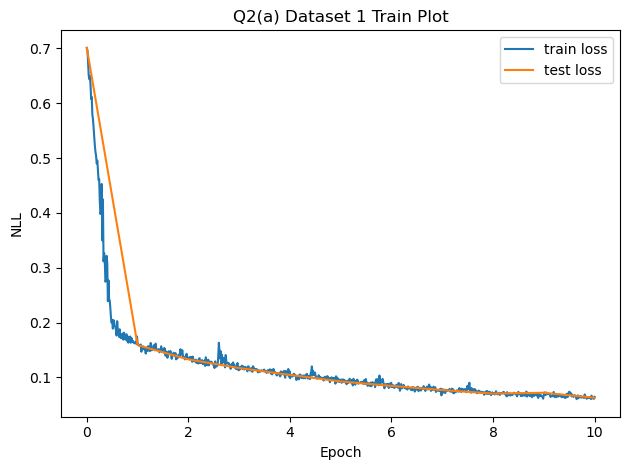

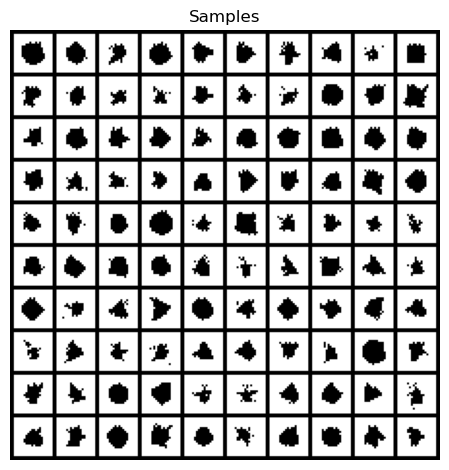

In [12]:
q2a_save_results(1, q2_a)

  0%|          | 0/10 [00:00<?, ?it/s]

Final Test Loss: 0.0787


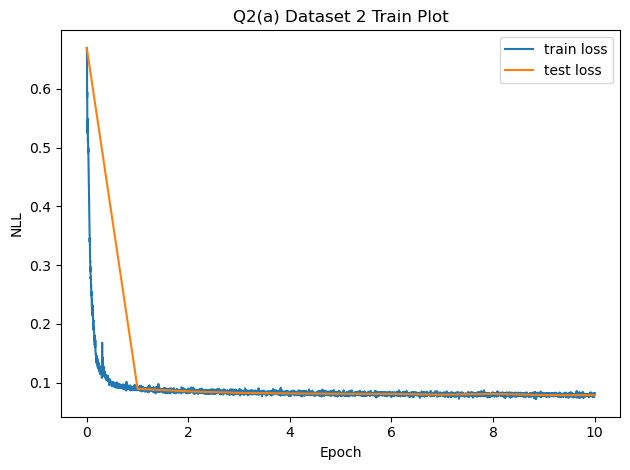

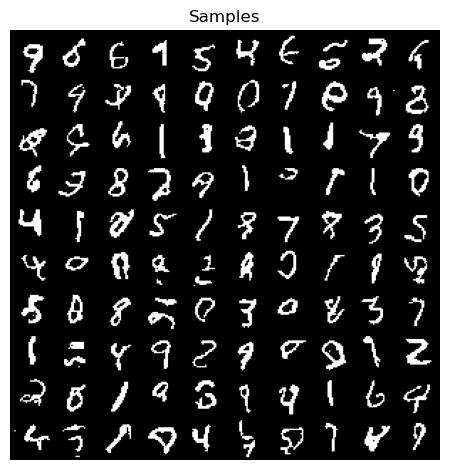

In [13]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

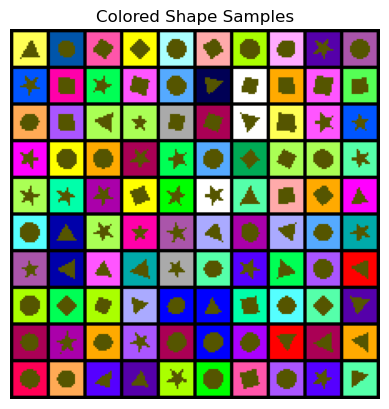

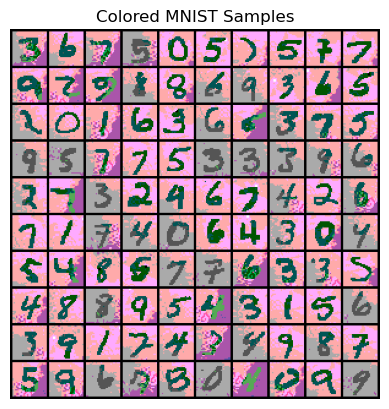

In [14]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, num_filters):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReLU(), MaskConvolution(num_filters * 2, num_filters, kernel_size=1, mask_type='B'),
        nn.ReLU(), MaskConvolution(num_filters, num_filters, kernel_size=7, mask_type='B'),
        nn.ReLU(), MaskConvolution(num_filters, num_filters * 2, kernel_size=1, mask_type='B'),
    )

  def forward(self, x):
    return x + self.layers(x)


class ChannelOnlyLayerNorm(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.layer_norm = nn.LayerNorm(num_channels)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = self.layer_norm(x)
        x = x.permute(0, 3, 1, 2)
        return x


class ColorPixelCNN(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, out_channels=1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(MaskConvolution(in_channels, 2 * hidden_channels, kernel_size=7, mask_type='A'))
        for _ in range(8):
            self.layers.extend([ResidualBlock(hidden_channels), ChannelOnlyLayerNorm(2*hidden_channels)])
        self.layers.extend([nn.ReLU(), MaskConvolution(2*hidden_channels, hidden_channels, kernel_size=1, mask_type='B'),
                            nn.ReLU(), MaskConvolution(hidden_channels, 12, kernel_size=1, mask_type='B')])

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        '''return 4 logits for each pixel color channel'''
        for layer in self.layers:
            x = layer(x)
        return x
    
    def loss(self, x):
        '''x: (B, 3, H, W)'''
        logits = self.forward(x) # (B, 3*4, H, W)
        B, C, H, W = logits.shape
        logits = logits.reshape(3*B, C // 3, -1) # flatten the logits (B, 3*4, H, W) -> (3*B, 4, H*W)
        gt = x.reshape(3*B, -1).long() # flatten the target for consistent matching with the logits (B, 3, H, W) -> (3*B, H*W)
        return F.cross_entropy(logits, gt)    

    @torch.no_grad()
    def test_loss(self, test_loader) -> float:
        self.eval()
        total_loss, total_count = 0.0, 0
        for x in test_loader:
            x = x.to(self.device)
            batch_size = x.shape[0]
            total_loss += self.loss(x).item() * batch_size
            total_count += batch_size
        return total_loss / total_count

    @torch.no_grad()
    def sample(self, N, image_shape):
        H, W, _ = image_shape
        num_dims = H * W
        samples = torch.zeros(N, 3, H, W).to(self.device)
        for i in range(num_dims):
            logits = self.forward(samples)
            logits_i = logits.reshape(3*N, 4, H*W)[:, :, i]
            probs_i = F.softmax(logits_i, dim=1)
            predict = torch.multinomial(probs_i, 1)
            samples.reshape(3*N, H*W)[:, i] = predict.squeeze()
        return samples.long()


def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    train_tensor = torch.tensor(train_data).permute(0, 3, 1, 2).float()
    test_tensor = torch.tensor(test_data).permute(0, 3, 1, 2).float()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_channel, out_channel = 3, 3
    lr, epochs, batch_size, filters = 3e-4, 20, 128, 120

    model = ColorPixelCNN(in_channel, filters, out_channel).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(
        train_tensor, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)

    train_losses, test_losses = [], []
    test_losses.append(model.test_loss(test_loader))

    for epoch in tqdm(range(epochs)):
        model.train()
        for batch, x in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_losses.append(model.test_loss(test_loader))

    samples = model.sample(
        100, image_shape).cpu().numpy().transpose(0, 2, 3, 1)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Loss: 0.0445


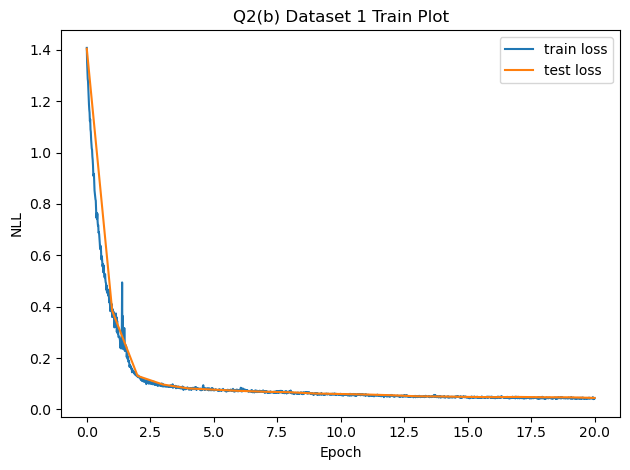

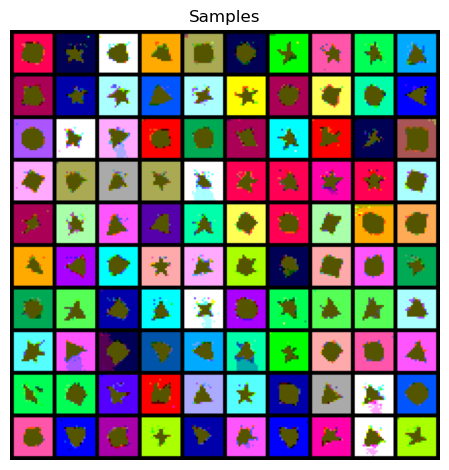

In [21]:
q2b_save_results(1, 'b', q2_b)

  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Loss: 0.1243


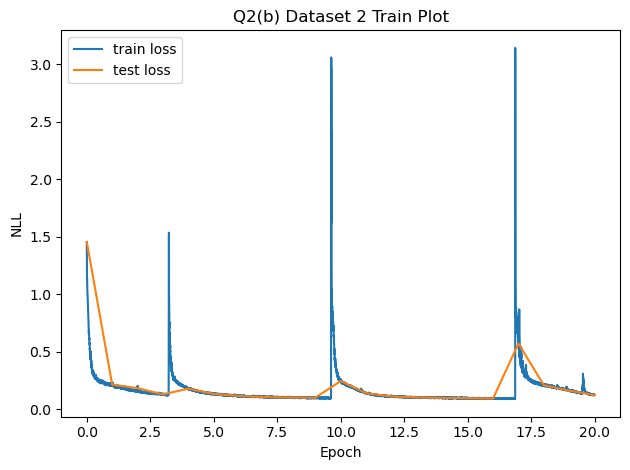

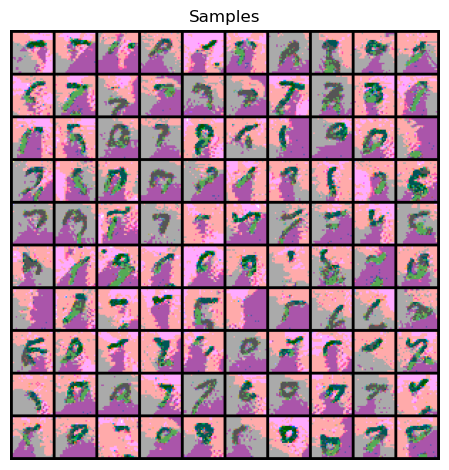

In [17]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'a', q3_a)

In [ ]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

In [ ]:
q3ab_save_results(1, 'b', q3_b)

In [ ]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image.

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience.

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  return autoencoded_images

In [ ]:
q4a_save_results(1, q4_a)

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

In [ ]:
q4b_save_results(2, q4_b)